# TP 3 : Inversion Bayésienne pour l'étude du fonctionnement du lit de la rivière

__2 séances__

Dans ce TP on va mener une inversion du modèle de transfert de chaleur en milieu poreux en régime permanent à partir d'une simulation de référence échantillonnée en 4 points. Le transfert de chaleur a lieu dans une portion de zone hyporhéique mono-dimensionnelle de hauteur 1m représentée par 100 cellules. La différence de charge entre le haut et le bas de la colonne est fixée à 5cm.

L'inversion portera sur les trois paramètres incertains de ce modèle, à savoir :

- la perméabilité $K$
- la conductivité thermique du solide $\lambda_s$
- la porosité $n$

On va considérer (loi a priori) que ces variables sont indépendantes de lois respectives :

- $-\log_{10} K \sim \mathcal{U}(3,10)$
- $\lambda_s \sim \mathcal{U}(1,5)$
- $n \sim \mathcal{U}(0.01,0.25)$

Les points de mesure sont disposés le long de la colonne aux positions 20 cm, 40 cm, 60 cm et 80 cm.

## 1. Simulation de référence et échantillonnage
### 1.1 Simulation de référence
On choisit (on pourrait aussi les générer aléatoirement) des valeurs de référence pour les trois paramètres, compatibles avec la loi a priori.


Populating the interactive namespace from numpy and matplotlib
Caracteristics of the soil column:
	depth 1.0 m
	depth 1.0 m
	 100 cells of side size 0.01 m
Hydraulic Properties of porous media Unknown
	permeability or hydraulic conductivity: 1.000e-04 m s-1
	porosity: 1.500e-01 --
Thermal Properties of the phase (pure solid) Soil Column
	thermal conductivity:: 2.000e+00 W m-1 K-1
	specific heat capacity:: 9.570e+02 m2 s-2 K-1
	density:: 2.600e+03 kg m-3
equivalent parameters of  Soil Column :
	equivalent thermal conductivity: : 1.737e+00 W m-1 K-1
	equivalent heat capacity: : 2.743e+06 W m-1 K-1
effective parameters of {}:
 Soil Column
	effective thermal conductivity: 4.151e-07 m2 s-1
	effective advective parameter: 1.526e-04 m s-1
Running pyHeat in steady state with the following specs:
	Hydraulic Boundary Conditions:
		differential pressure head (top - bottom) = 0.05 m
	Temperature Boundary Conditions:
		Triv = 302.15 K
		Taq = 285.15 K
	Physical properties :
		permeability:: 1.000e-

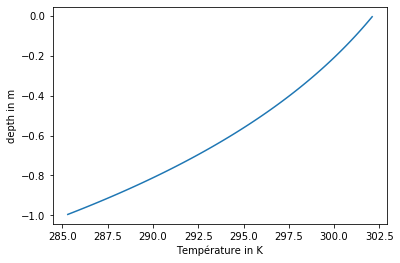

In [95]:
%pylab inline

from codepyheat.geometry import Column
from codepyheat import JSONPATH

K_ref = 1e-5
lambda_s_ref = 2
n_ref = 0.1

# step 1
dico = {
    "depth": {
            "val": "1",
            "unit": "m"
        },
    "ncells": 100
}

rivBed = Column(dico)
rivBed.printProps()

# step 2
rivBed.setHomogeneousPorMed(JSONPATH + "paramColumn.json")
rivBed.physProp.printProps()

# step 3
rivBed.setBcHyd(JSONPATH + "configBcHydro.json")
rivBed.setBcT(JSONPATH + "configBcTemp.json")

# step 4 running forward model with other parameter values
ref = rivBed.runForwardModelSteadyState(K_ref, lambda_s_ref, n_ref)


### Echantillonnage

Extraire les valeurs de température aux points de mesure et les *perturber* en y additionnant une gaussienne centrée de variance $\sigma^2 = 1$, correspondant à l'erreur de mesure.
        

In [98]:
datapoints = np.array((19,39,59,79))
npoints = len(datapoints)
data = np.zeros(npoints)
for i in range(npoints):    
        data[i] = ref[datapoints[i]] + np.random.normal()

In [99]:
print(data)

[300.82622716 298.55879928 294.04871465 289.05796658]


## 2. Inversion

On va implémenter un algorithme MCMC de type marche aléatoire à incréments symétriques (SIMH) avec une loi propositionnelle gaussienne.

### 2.1 Lois a priori

Les lois a priori considérées sont toutes uniformes. Elles sont donc caractérisées par leur intervalle de variation.

In [100]:
range_moinslog10K = [3,10]
range_lambda_s = [1,5]
range_n = [.01,.25]


### 2.2 Paramétrisation

Choix des valeurs des écarts types pour chacun des paramètres et l'erreur de mesure. Les valeurs suivantes sont proposées en première intention, on pourra les modifier si besoin.

In [101]:
sigma_moinslog10K = 1
sigma_lambda_s = .5
sigma_n = .06

sigma_obs = 1

### 2.3 Modèle direct

Ecrire une fonction qui renvoie une liste contenant les valeurs du modèle direct aux points de données ainsi que le profil de température complet.

In [102]:
def forward(moinslog10K,lambda_s,n,datapoints):
    res = rivBed.runForwardModelSteadyState(10**(-moinslog10K), lambda_s, n, verbose=False, export = False, draw = False)
    #res = list(numpy.concatenate(res).flat)  # NF now included in runForwardModelSteadyState
    npoints = len(datapoints)
    data = np.zeros(npoints)
    for i in range(npoints):    
        data[i] = res[datapoints[i]]
    return([data,res])



Ecrire une fonction qui calcule l'énergie du système. On rappelle que cette quantité est indicative et va nous servir à visualiser l'entrée de la chaîne en régime stationnaire.

In [103]:
def compute_energy(data,data_cur,sigma_obs):
    return(np.sum((data-data_cur)**2)/(2*sigma_obs**2))

### 2.4 Initialisation

Initialiser la chaîne en générant une valeur de chacun des paramètres selon le prior, appliquer le modèle direct et calculer l'énergie.

In [104]:
moinslog10K_cur = np.random.uniform(range_moinslog10K[0],range_moinslog10K[1])
lambda_s_cur = np.random.uniform(range_lambda_s[0],range_lambda_s[1])
n_cur = np.random.uniform(range_n[0],range_n[1])
[data_cur,temp_cur] = forward(moinslog10K_cur,lambda_s_cur,n_cur,datapoints)
energy_cur = compute_energy(data,data_cur,sigma_obs)
print(energy_cur)

8.970642363155497


Choisir le nombre d'itérations et initialiser les tableaux qui contiendront :
 
 - les valeurs des paramètres
 - l'énergie des états générés
 - la moyenne des taux d'acceptation
 - les profils de température

In [105]:
# NIT = 1000000
NIT = 5000

params = np.zeros((NIT,3))
params[0,] = [moinslog10K_cur,lambda_s_cur,n_cur]
energy = np.zeros(NIT)
energy[0] = energy_cur
mean_alpha = np.zeros(NIT)
mean_alpha[0] = 1
temp = np.zeros((NIT,len(ref)))
temp[0,:] = temp_cur

### 2.5 Noyau propositionnel

Ecrire une fonction qui perturbe l'état courant d'un paramètre tout en respectant le prior (notamment ses bornes)

In [106]:
def prop(param_cur,range_param,sigma_param):
    u = np.random.normal(0,sigma_param)
    param_prop = param_cur
    if (param_cur+u<range_param[0]):
        param_prop = param_prop+u-range_param[0]+range_param[1]
    elif(param_cur + u >range_param[1]):
        param_prop = param_prop+u-range_param[1]+range_param[0]
    else:
        param_prop = param_prop+u
    return(param_prop)


## 3. MCMC

### 3.1 Variance d'erreur de mesure connue

Dans un premier temps, on suppose la variance de l'erreur d'estimation connue, implémenter l'agorithme MCMC

In [107]:
for i in range(NIT-1):
    moinslog10K_prop = prop(moinslog10K_cur,range_moinslog10K,sigma_moinslog10K)
    lambda_s_prop = prop(lambda_s_cur,range_lambda_s,sigma_lambda_s)
    n_prop = prop(n_cur,range_n,sigma_n)
    [data_prop,temp_prop] = forward(moinslog10K_prop,lambda_s_prop,n_prop,datapoints)
    energy_prop = compute_energy(data,data_prop,sigma_obs)
    alpha = np.min([1,np.exp(energy_cur - energy_prop)])
    u = np.random.rand(1)
    if (u< alpha):
        moinslog10K_cur = moinslog10K_prop
        lambda_s_cur = lambda_s_prop
        n_cur = n_prop
        energy_cur = energy_prop
        temp_cur = temp_prop
    params[i+1,] = [moinslog10K_cur,lambda_s_cur,n_cur]
    energy[i+1] = energy_cur
    mean_alpha[i+1] = (mean_alpha[i]*(i+1) + alpha)/(i+2)
    temp[i+1,:] = temp_cur


Représenter graphiquement l'énergie et la probabilité d'acceptation estimée.

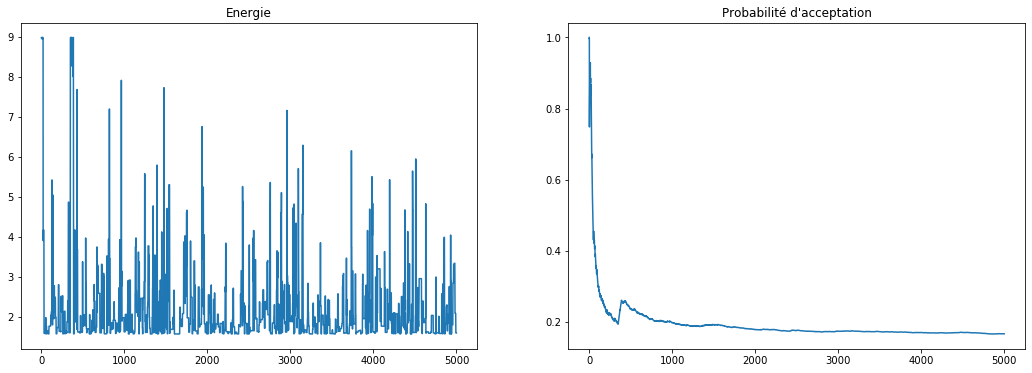

In [108]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18, 6))
ax1.set_title("Energie")
fig1 = ax1.plot(energy)

ax2.set_title("Probabilité d'acceptation")
fig2 = ax2.plot(mean_alpha)
plt.show()

Le graphe des énergies indique que la chaîne est entrée presque immédiatement en régime stationnaire. La probabilité d'acceptation moyenne, assez faible suggère de réduire la variance de la perturbation de la marche aléatoire.

A partir des échantillons générés, représenter les histogrammes a posteriori des trois paramètres.

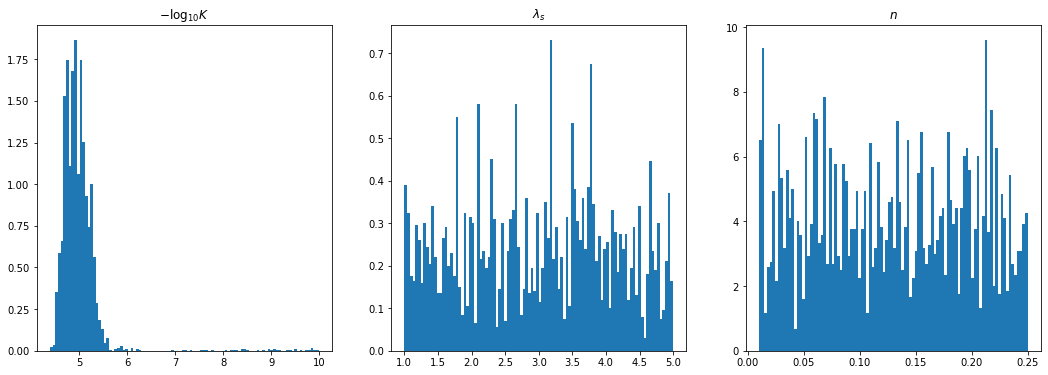

In [109]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(18, 6))
ax1.set_title("$-\log_{10} K$")
fig1 = ax1.hist(params[:,0],100,density=True)

ax2.set_title("$\lambda_s$")
fig2 = ax2.hist(params[:,1],100,density=True)

ax3.set_title("$n$")
fig3 = ax3.hist(params[:,2],100,density=True)
plt.show()


On peut voir que l'histogramme de $-\log_{10} K$ est bien centré sur la valeur attendue. Les deux autres histogrammes sont plus difficile à interpréter, c'est pourquoi on va maintenant étudier la dépendance entre les couples de paramètres en représentant les histogrammes bidimensionnels.

Représenter maintenant les couples d'histogrammes bivariés à l'aide de la fonction `plt.hist2d`

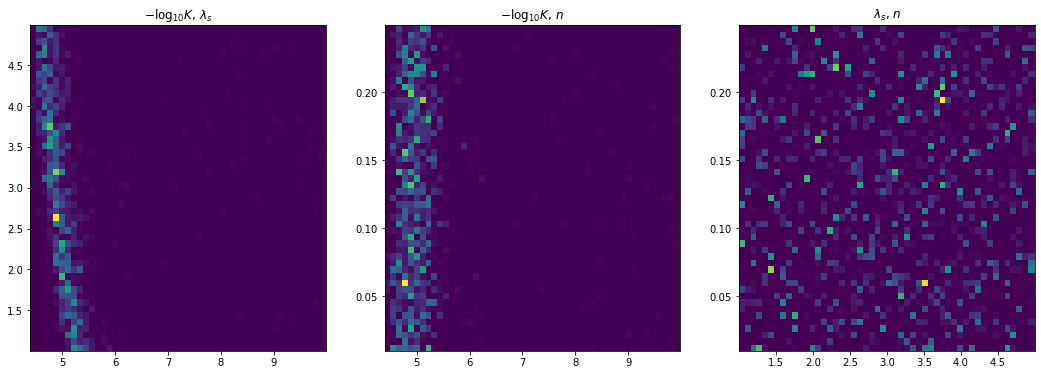

In [110]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(18, 6))
ax1.set_title("$-\log_{10} K$, $\lambda_s$")
fig1 = ax1.hist2d(params[:,0],params[:,1],50)

ax2.set_title("$-\log_{10} K$, $n$")
fig2 = ax2.hist2d(params[:,0],params[:,2],50)

ax3.set_title("$\lambda_s$, $n$")
fig3 = ax3.hist2d(params[:,1],params[:,2],50)
plt.show()

Représenter le profil médian ainsi que les quantiles (cellule par cellule) à 2.5% et 97.5%. Comparer avec le profil de référence et les données bruitées.

100


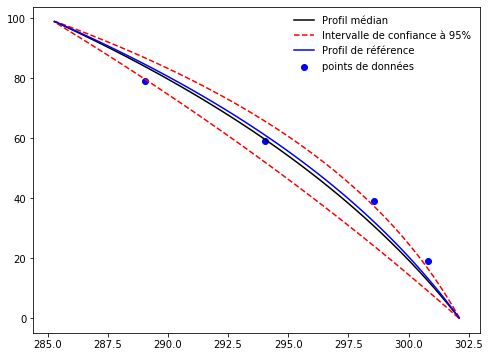

In [111]:
def calcQuant(temp):
    lenVec = len(temp[0,:])
    quant_temp = np.zeros((3,lenVec))
    for i in range(lenVec):
        quant_temp[:,i] = np.quantile(temp[:,i],[.025,.5,.975])
    return quant_temp
    
quant_temp = calcQuant(temp)

depth = range(len(ref))

fig, ax = plt.subplots(figsize=(8, 6))

plt.plot(quant_temp[1,:],depth,'-k',label = 'Profil médian')
plt.plot(quant_temp[2,:],depth,'--r',label = 'Intervalle de confiance à 95%')
plt.plot(quant_temp[0,:],depth,'--r',)
plt.plot(ref,depth,'-b', label ='Profil de référence')
plt.scatter(data,datapoints,c='b', label ='points de données')
plt.legend(loc='best', frameon=False)

plt.show()

### 3.2 Estimation de la variance d'erreur de mesure

On suppose désormais que $\sigma_{OBS} \sim \mathcal{U}_{[0.25,2]}$. Implémenter un algorithme MCMC qui réalise également l'inférence bayésienne sur ce paramètre. Reprendre les questions précédentes avec ces nouveaux résultats.

In [114]:
# paramétrisation

range_sigma_obs = [0.25,2]
sigma_sigma_obs = .1

# Initialisation
moinslog10K_cur = np.random.uniform(range_moinslog10K[0],range_moinslog10K[1])
lambda_s_cur = np.random.uniform(range_lambda_s[0],range_lambda_s[1])
n_cur = np.random.uniform(range_n[0],range_n[1])
sigma_obs_cur = np.random.uniform(range_sigma_obs[0],range_sigma_obs[1])
[data_cur,temp_cur] = forward(moinslog10K_cur,lambda_s_cur,n_cur,datapoints)
energy_cur = compute_energy(data,data_cur,sigma_obs_cur)

#NIT = 1000000 # On garde la même valeur de NIT que précédemment pour être cohérent

params2 = np.zeros((NIT,4))
params2[0,] = [moinslog10K_cur,lambda_s_cur,n_cur,sigma_obs_cur]
energy = np.zeros(NIT)
energy[0] = energy_cur
mean_alpha = np.zeros(NIT)
mean_alpha[0] = 1
temp = np.zeros((NIT,len(ref)))
temp[0,:] = temp_cur

# MCMC

for i in range(NIT-1):
    moinslog10K_prop = prop(moinslog10K_cur,range_moinslog10K,sigma_moinslog10K)
    lambda_s_prop = prop(lambda_s_cur,range_lambda_s,sigma_lambda_s)
    n_prop = prop(n_cur,range_n,sigma_n)
    sigma_obs_prop = prop(sigma_obs_cur,range_sigma_obs,sigma_sigma_obs)
    [data_prop,temp_prop] = forward(moinslog10K_prop,lambda_s_prop,n_prop,datapoints)
    energy_prop = compute_energy(data,data_prop,sigma_obs_prop)
    alpha = np.min([1,(sigma_obs_cur/sigma_obs_prop)**4 * np.exp(energy_cur - energy_prop)])
    u = np.random.rand(1)
    if (u< alpha):
        moinslog10K_cur = moinslog10K_prop
        lambda_s_cur = lambda_s_prop
        n_cur = n_prop
        sigma_obs_cur = sigma_obs_prop
        energy_cur = energy_prop
        temp_cur = temp_prop
    params2[i+1,] = [moinslog10K_cur,lambda_s_cur,n_cur,sigma_obs_cur]
    energy[i+1] = energy_cur
    mean_alpha[i+1] = (mean_alpha[i]*(i+1) + alpha)/(i+2)
    temp[i+1,:] = temp_cur



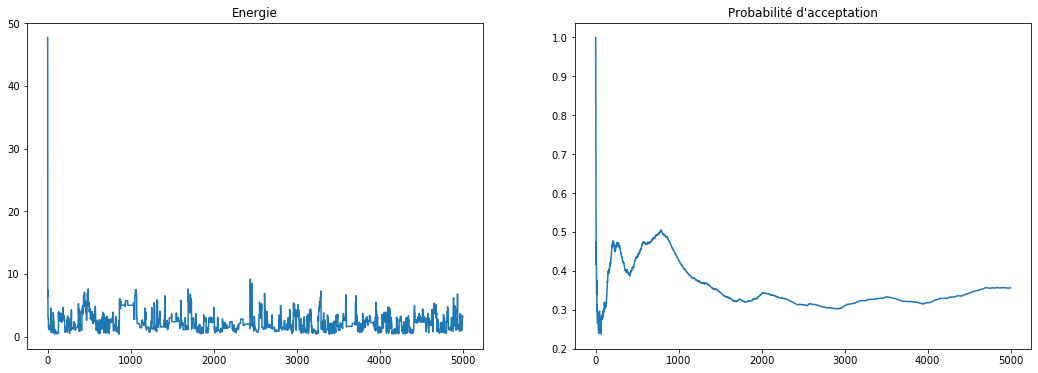

In [115]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18, 6))
ax1.set_title("Energie")
fig1 = ax1.plot(energy)

ax2.set_title("Probabilité d'acceptation")
fig2 = ax2.plot(mean_alpha)
plt.show()

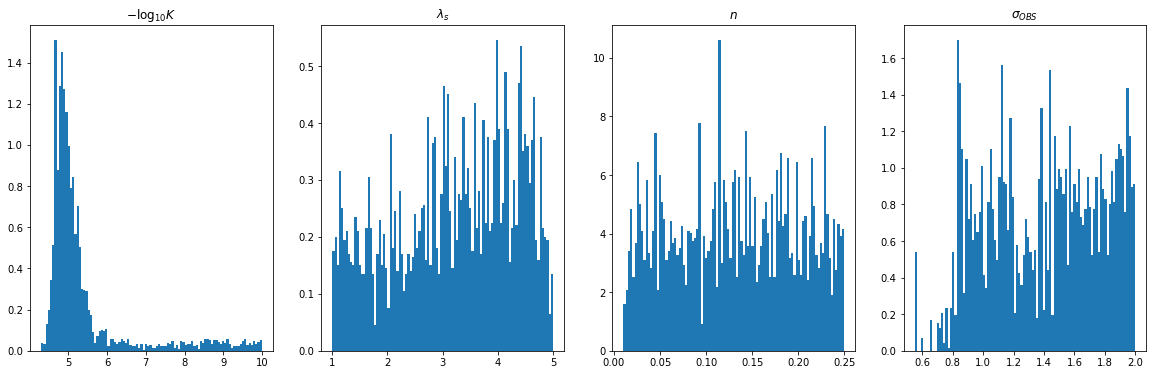

In [113]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(20, 6))
ax1.set_title("$-\log_{10} K$")
fig1 = ax1.hist(params2[:,0],100,density=True)

ax2.set_title("$\lambda_s$")
fig2 = ax2.hist(params2[:,1],100,density=True)

ax3.set_title("$n$")
fig3 = ax3.hist(params2[:,2],100,density=True)

ax4.set_title("$\sigma_{OBS}$")
fig4 = ax4.hist(params2[:,3],100,density=True)
plt.show()


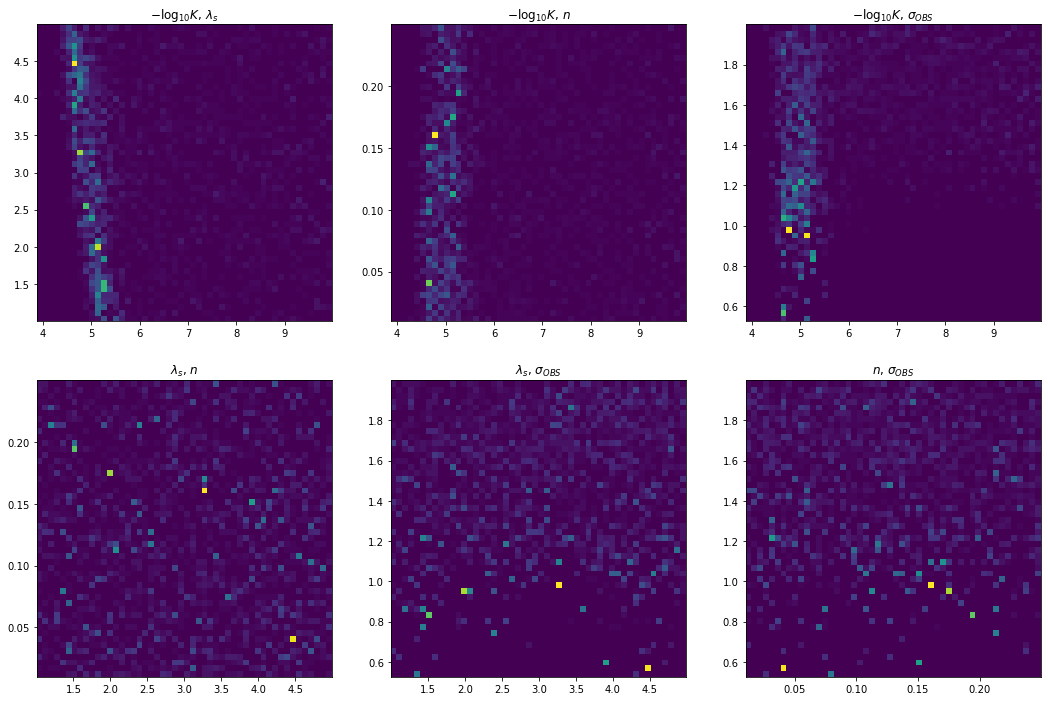

In [116]:
fig, axs = plt.subplots(2, 3,figsize=(18, 12))
axs[0,0].set_title("$-\log_{10} K$, $\lambda_s$")
axs[0,0].hist2d(params2[:,0],params2[:,1],50)

axs[0,1].set_title("$-\log_{10} K$, $n$")
axs[0,1].hist2d(params2[:,0],params2[:,2],50)

axs[0,2].set_title("$-\log_{10} K$, $\sigma_{OBS}$")
axs[0,2].hist2d(params2[:,0],params2[:,3],50)

axs[1,0].set_title("$\lambda_s$, $n$")
axs[1,0].hist2d(params2[:,1],params2[:,2],50)

axs[1,1].set_title("$\lambda_s$, $\sigma_{OBS}$")
axs[1,1].hist2d(params2[:,1],params2[:,3],50)

axs[1,2].set_title("$n$, $\sigma_{OBS}$")
axs[1,2].hist2d(params2[:,2],params2[:,3],50)

plt.show()

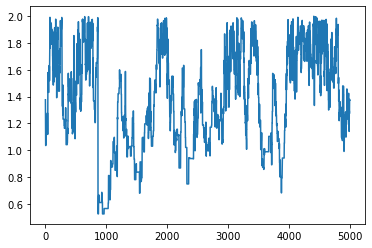

In [117]:
plt.plot(params2[:,3])
plt.show()

100


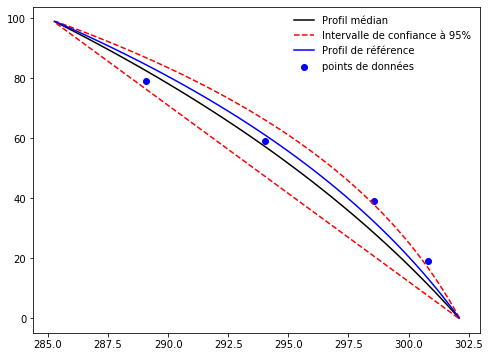

In [118]:
quant_temp = calcQuant(temp)

depth = range(len(ref))

fig, ax = plt.subplots(figsize=(8, 6))

plt.plot(quant_temp[1,:],depth,'-k',label = 'Profil médian')
plt.plot(quant_temp[2,:],depth,'--r',label = 'Intervalle de confiance à 95%')
plt.plot(quant_temp[0,:],depth,'--r',)
plt.plot(ref,depth,'-b', label ='Profil de référence')
plt.scatter(data,datapoints,c='b',label ='points de données')
plt.legend(loc='best', frameon=False)

plt.show()

## 4. Etude du fonctionnement du lit de la rivière en régime permanent

Dans cette partie, on étudie les écoulements dans le lit de la rivière suivant :
+ différents forçages hydrauliques 
+ différents forçages thermiques 
+ différents champs de paramètres. 

Au moins trois situations hydrodynamiques et thermiques seront considérées.

### 4.1. Ecoulement hivernal de la rivière vers la nappe

On suppose une pression différentielle de 10 cm entre la rivière et la nappe. 

La température de l'eau de rivière est de 2$^{\circ} C$, alors que celle des eaux souterraines est de 16$^{\circ} C$.

Résolvez le transport de chaleur dans cette configuration en balayant des valeurs de paramètres appropriées. A cet effet, on considère que la première partie du TP a permis de caractériser les distributions statistiques des trois paramètres que sont la perméabilité, la conductivité thermique, et la porosité, et de manière optionnelle l'erreur de mesure.

Discutez les résultats.



Tout d'abord, on écrit une méthode de lancement de plusieurs simulations (nit) en steady state, et une methode de plot des résultats

In [131]:
def runMultiSimul(param,nit=NIT,dp=datapoints):
    temp = np.zeros((nit,rivBed.ncells))
    for i in range(nit-1):
        moinslog10K_prop = param[i,0]
        lambda_s_prop = param[i,1]
        n_prop = param[i,2]
        [data_prop,temp[i,:]] = forward(moinslog10K_prop,lambda_s_prop,n_prop,dp)
        
    print("Multiple simulations ran with")
    rivBed.printBcHydSteady()
    rivBed.printBcTempSteady()
    return temp

def plotProfilQuantile(quant_temp):
    z = rivBed.generateZAxis()  
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(quant_temp[1,:],z,'-k',label = 'Profil médian')
    plt.plot(quant_temp[2,:],z,'--r',label = 'Intervalle de confiance à 95%')
    plt.plot(quant_temp[0,:],z,'--r',)
    plt.legend(loc='best', frameon=False)
    plt.show()


Ensuite, on fixe les conditions limites, puis on effectue ensuite une série de simulations dont on trace le résultat


Multiple simulations ran with
	Hydraulic Boundary Conditions:
		differential pressure head (top - bottom) = 0.1 m
	Temperature Boundary Conditions:
		Triv = 275.15 K
		Taq = 289.15 K
100


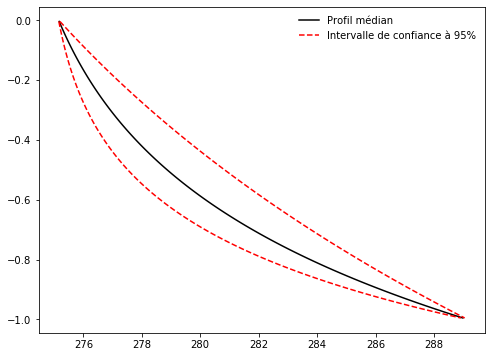

Multiple simulations ran with
	Hydraulic Boundary Conditions:
		differential pressure head (top - bottom) = 0.1 m
	Temperature Boundary Conditions:
		Triv = 275.15 K
		Taq = 289.15 K
100


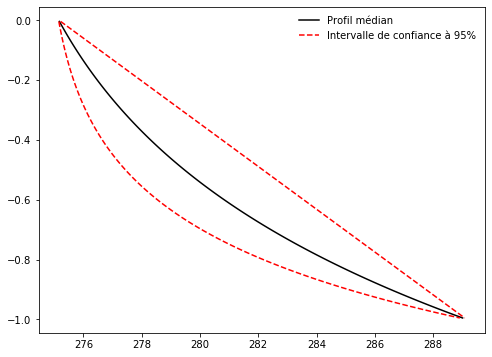

In [128]:
from codepyheat.hydrogeol import BoundaryConditionHyd
from codepyheat.heat import BoundaryConditionHeat
dico =  {
    "dH" : {
        "val": 10,
        "unit": "cm"
        }
        }
bchyd = BoundaryConditionHyd(dico)
rivBed.setBcHydObj(bchyd)
dicoT =  {
    "Triv" : {
        "val" : 2,
        "unit" : "°C"
        },
    "Taq" : {
        "val" : 16,
        "unit" : "°C"
        }
    }
bcT = BoundaryConditionHeat(dicoT)
rivBed.setBcTObj(bcT)

temp1 = runMultiSimul(params)
plotProfilQuantile(calcQuant(temp1))
temp2 = runMultiSimul(params2)
plotProfilQuantile(calcQuant(temp2))

In [ ]:
### 4.2. Ecoulement estival de la nappe vers la rivière

On suppose une pression différentielle de -5 cm cm entre la rivière et la nappe. 

La température de l'eau de rivière est de 28$^{\circ} C$, alors que celle des eaux souterraines de 14$^{\circ} C$.

Résolvez le transport de chaleur dans cette configuration en balayant des valeurs de paramètres appropriées. A cet effet, on considère que la première partie du TP a permis de caractériser les distributions statistiques des trois paramètres que sont la perméabilité, la conductivité thermique, et la porosité, et de manière optionnelle l'erreur de mesure.

Discutez les résultats.


Multiple simulations ran with
	Hydraulic Boundary Conditions:
		differential pressure head (top - bottom) = -0.05 m
	Temperature Boundary Conditions:
		Triv = 301.15 K
		Taq = 287.15 K
100


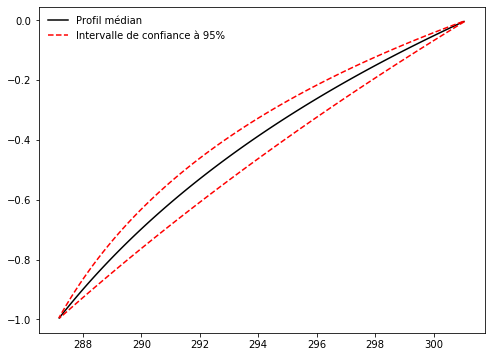

Multiple simulations ran with
	Hydraulic Boundary Conditions:
		differential pressure head (top - bottom) = -0.05 m
	Temperature Boundary Conditions:
		Triv = 301.15 K
		Taq = 287.15 K
100


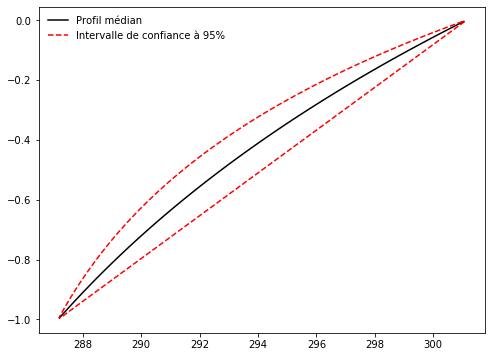

In [129]:
from codepyheat.heat import BoundaryConditionHeat
dico =  {
    "dH" : {
        "val": -5,
        "unit": "cm"
        }
        }
bchyd = BoundaryConditionHyd(dico)
rivBed.setBcHydObj(bchyd)
dicoT =  {
    "Triv" : {
        "val" : 28,
        "unit" : "°C"
        },
    "Taq" : {
        "val" : 14,
        "unit" : "°C"
        }
    }
bcT = BoundaryConditionHeat(dicoT)
rivBed.setBcTObj(bcT)

temp1 = runMultiSimul(params)
plotProfilQuantile(calcQuant(temp1))
temp2 = runMultiSimul(params2)
plotProfilQuantile(calcQuant(temp2))

In [ ]:

### 4.3. Configuration d'intérêt pour vous

Réalisez le même travail pour une situation d'intérêt selon vous. Argumentez le pourquoi puis résolvez le problème.

In [ ]:
On s'intéresse ici à une crue printannière comme cela a été le cas en juin 2016. Nous simplifions ici à l'extrême ce phénomène dans un cadre permanent en posant :

On suppose une pression différentielle de +25 cm cm entre la rivière et la nappe. 

La température de l'eau de rivière est de 28$^{\circ} C$, alors que celle des eaux souterraines de 14$^{\circ} C$.


Multiple simulations ran with
	Hydraulic Boundary Conditions:
		differential pressure head (top - bottom) = 0.25 m
	Temperature Boundary Conditions:
		Triv = 301.15 K
		Taq = 287.15 K
100


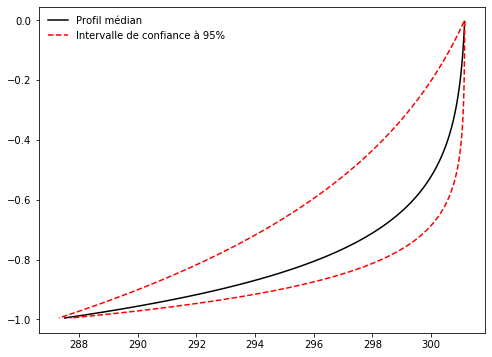

Multiple simulations ran with
	Hydraulic Boundary Conditions:
		differential pressure head (top - bottom) = 0.25 m
	Temperature Boundary Conditions:
		Triv = 301.15 K
		Taq = 287.15 K
100


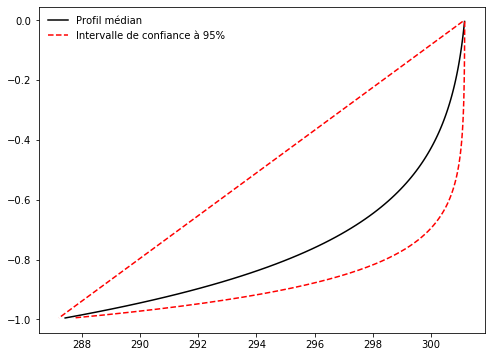

In [130]:
dico =  {
    "dH" : {
        "val": 25,
        "unit": "cm"
        }
        }
bchyd = BoundaryConditionHyd(dico)
rivBed.setBcHydObj(bchyd)
temp1 = runMultiSimul(params)
plotProfilQuantile(calcQuant(temp1))
temp2 = runMultiSimul(params2)
plotProfilQuantile(calcQuant(temp2))

In [ ]:
On remarque une plus forte propagation de la condition limite lorsque les différences de charges sont importantes. Les IC 95% sup ont des épaisseurs raisonnables pour un échantillonage de 5000. Les simulations sont plus précises en considérant les erreurs de mesure connues. Dans le cas contraire, le champs des possibles est beaucoup plus large, pouvant même estimer des modes de fonctionnement purement diffusifs.

On pourrait évaluer l'impact du nombre de simulations sur ces résultats. en faisant varier NIT et en évaluant la largeur de l'intervalle de confiance.

